In [73]:
# Data Processing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Imbalanced Data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

# Modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [74]:
cleaned_churners = pd.read_csv('churners_clean_df.csv')

In [105]:
# Replace Unknown values by nan in categorical data
cleaned_churners.replace('Unknown', np.nan, inplace=True)

### Imbalanced data

In [76]:
X = cleaned_churners.drop('Attrition_Flag', axis=1)
y = cleaned_churners['Attrition_Flag']

In [77]:
print (type(X))

<class 'pandas.core.frame.DataFrame'>


Class distribution

In [78]:
y.value_counts()

Attrition_Flag
Existing Customer    6970
Attrited Customer    1365
Name: count, dtype: int64

<Axes: ylabel='count'>

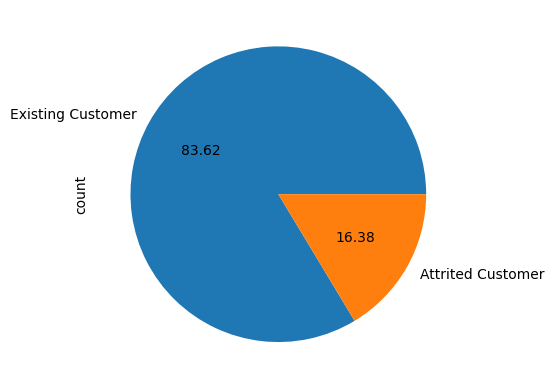

In [79]:
y.value_counts().plot.pie(autopct='%.2f')

Random Undersampling <br>
'not minority' = resample all classes but the minority class

Attrition_Flag
Attrited Customer    1365
Existing Customer    1365
Name: count, dtype: int64

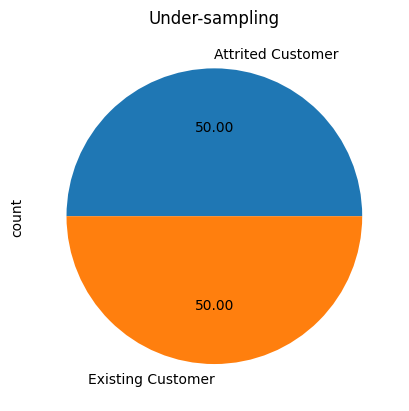

In [80]:
rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_rus, y_rus = rus.fit_resample(X, y)

ax = y_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

# Class distribution after resampling
y_rus.value_counts()

Random Oversampling <br>
"not majority" = resample all classes but the majority class

Attrition_Flag
Existing Customer    6970
Attrited Customer    6970
Name: count, dtype: int64

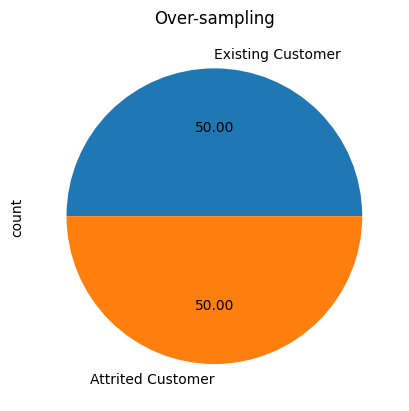

In [81]:
# ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_ros, y_ros = ros.fit_resample(X, y)

ax = y_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

y_ros.value_counts()

SMOTENC: SMOTE with categorical features

In [82]:
display(X.head())

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,1.376,1088,24,0.846,0.311
1,42,M,5,Uneducated,NaN,$120K +,Blue,31,5,3,2,6748.0,1467,0.831,1201,42,0.680,0.217
2,57,F,2,Graduate,Married,Less than $40K,Blue,48,5,2,2,2436.0,680,1.190,1570,29,0.611,0.279
3,47,M,1,Doctorate,Divorced,$60K - $80K,Blue,42,5,2,0,20979.0,1800,0.906,1178,27,0.929,0.086
4,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1.047,692,16,0.600,0.000


In [83]:
sm = SMOTENC(sampling_strategy="minority", categorical_features=[1,3,4,5,6])
X_sm, y_sm = sm.fit_resample(X, y)

Training

In [114]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=42, test_size=0.3)

In [85]:
num_cols = X_train.select_dtypes(exclude='object').columns
cat_cols = X_train.select_dtypes(include='object').columns

In [86]:
# Define preprocessing steps for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1,
    verbose=True)

In [87]:
# Select the columns with categorical values
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("columns_to_encode =", categorical_cols)

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(X_train[categorical_cols])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the encoded DataFrame with the original DataFrame
result_df = pd.concat([X_train, encoded_df], axis=1)

# Drop the original categorical columns if needed
result_df.drop(columns = categorical_cols, axis=1, inplace=True) 

print(result_df.info())
result_df.isna().sum().sort_values(ascending=False)

columns_to_encode = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
<class 'pandas.core.frame.DataFrame'>
Index: 12717 entries, 9436 to 9757
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_Age                    9758 non-null   float64
 1   Dependent_count                 9758 non-null   float64
 2   Months_on_book                  9758 non-null   float64
 3   Total_Relationship_Count        9758 non-null   float64
 4   Months_Inactive_12_mon          9758 non-null   float64
 5   Contacts_Count_12_mon           9758 non-null   float64
 6   Credit_Limit                    9758 non-null   float64
 7   Total_Revolving_Bal             9758 non-null   float64
 8   Total_Amt_Chng_Q4_Q1            9758 non-null   float64
 9   Total_Trans_Amt                 9758 non-null   float64
 10  Total_Trans_Ct                  9758 non-null   float

Customer_Age                      2959
Income_Category_$120K +           2959
Education_Level_Uneducated        2959
Education_Level_nan               2959
Marital_Status_Divorced           2959
Marital_Status_Married            2959
Marital_Status_Single             2959
Marital_Status_nan                2959
Income_Category_$40K - $60K       2959
Education_Level_High School       2959
Income_Category_$60K - $80K       2959
Income_Category_$80K - $120K      2959
Income_Category_Less than $40K    2959
Card_Category_Blue                2959
Card_Category_Gold                2959
Card_Category_Platinum            2959
Education_Level_Post-Graduate     2959
Education_Level_Graduate          2959
Dependent_count                   2959
Total_Amt_Chng_Q4_Q1              2959
Months_on_book                    2959
Total_Relationship_Count          2959
Months_Inactive_12_mon            2959
Contacts_Count_12_mon             2959
Credit_Limit                      2959
Total_Revolving_Bal      

In [88]:
# Fit and transform the preprocesing steps on the training data
preprocessed = preprocessor.fit(X_train)

X_train_processed = preprocessed.transform(X_train)
X_test_processed = preprocessed.transform(X_test)

Classifiers: KNN Classifier

In [89]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)

KNeighborsClassifier()

In [90]:
# Make predictions
y_pred = knn.predict(X_test_processed)

# Evaluate the model
print(round(knn.score(X_test_processed, y_test),2))

# Confusion matrix
confusion_matrix(y_test, y_pred)
crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
display(crosstab)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")


0.92


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2040,54,2094
Existing Customer,277,1811,2088
All,2317,1865,4182


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.88      0.97      0.92      2094
Existing Customer       0.97      0.87      0.92      2088

         accuracy                           0.92      4182
        macro avg       0.93      0.92      0.92      4182
     weighted avg       0.93      0.92      0.92      4182



Classifiers: Random Forest

In [91]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

In [92]:
# Make predictions
y_pred = rf_model.predict(X_test_processed)
y_prob = rf_model.predict_proba(X_test_processed)

# Evaluate the model
print(round(rf_model.score(X_test_processed, y_test),2))
print(round(roc_auc_score(y_test, y_prob[:,1]),2))

# Confusion matrix
confusion_matrix(y_test, y_pred)
crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
display(crosstab)

0.97
1.0


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2040,54,2094
Existing Customer,81,2007,2088
All,2121,2061,4182


In [93]:
# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")

Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.96      0.97      0.97      2094
Existing Customer       0.97      0.96      0.97      2088

         accuracy                           0.97      4182
        macro avg       0.97      0.97      0.97      4182
     weighted avg       0.97      0.97      0.97      4182



Classifiers: Decision Tree

In [94]:
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(X_train_processed, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [95]:
# Make predictions
y_pred = dt_clf.predict(X_test_processed)

# Evaluate the model
print(round(dt_clf.score(X_test_processed, y_test),2))

# Confusion matrix
confusion_matrix(y_test, y_pred)
crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
display(crosstab)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")


0.95


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2020,74,2094
Existing Customer,126,1962,2088
All,2146,2036,4182


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.94      0.96      0.95      2094
Existing Customer       0.96      0.94      0.95      2088

         accuracy                           0.95      4182
        macro avg       0.95      0.95      0.95      4182
     weighted avg       0.95      0.95      0.95      4182

